# Transfer Learning with TensorFlow part 3: Scaling up(Food vision mini)

We have seen the power of transfer learning feature extraction and fine-tuning, now it is time to scale up to all of the classes in Food101(101 total classes of the food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% across 101 classes.



In [ ]:
#check to see if you are using a GPU
!nvidia-smi

Tue Apr 16 15:30:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In the previous notebooks, we have created a series of helper functions to do differrent tasks. Let's download them

In [ ]:
!wget https://raw.githubusercontent.com/SangeethKumarPG/DS-DL/main/helper_functions.py

--2024-04-16 15:30:08--  https://raw.githubusercontent.com/SangeethKumarPG/DS-DL/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10128 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2024-04-16 15:30:09 (46.7 MB/s) - ‘helper_functions.py’ saved [10128/10128]



In [ ]:
#import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## 101 Food Classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download the data.

The data we are downloading comes from the original Food101 dataset but has been preprocessed using image_data_modification_notebook.

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
unzip_data("101_food_classes_10_percent.zip")

--2024-04-16 15:30:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.0MB/s    in 47s     

2024-04-16 15:31:01 (32.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


In [ ]:
# How many images/classes are theres?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_c

In [ ]:
#set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False,#don't shuffle data for prediction analysis
                                                                batch_size=32)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a big model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNEtB0 backboned model(we will create our own output layer)
* Compile the model
* Feature extract for 5 epochs on the train dataset and validate on 15% of test data (to save epoch time).


In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
# create dataugmnetaion layer to incorporate it right into the model
from tensorflow.keras import layers, Sequential

#setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name="data_augmentation")



In [ ]:
#creating efficientnetBo backbone model and freeze its layer
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
#freezing the layers of base model
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),
                       activation="softmax",
                       name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)




16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Get a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [ ]:
#compiling the mode
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
#fitting the model
history_model_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 161s 633ms/step - loss: 3.3700 - accuracy: 0.2729 - val_loss: 2.4319 - val_accuracy: 0.4669
Epoch 2/5
237/237 [==============================] - 105s 440ms/step - loss: 2.1989 - accuracy: 0.5059 - val_loss: 1.9632 - val_accuracy: 0.5331
Epoch 3/5
237/237 [==============================] - 88s 368ms/step - loss: 1.8268 - accuracy: 0.5667 - val_loss: 1.7884 - val_accuracy: 0.5551
Epoch 4/5
237/237 [==============================] - 84s 355ms/step - loss: 1.6044 - accuracy: 0.6149 - val_loss: 1.7386 - val_accuracy: 0.5548
Epoch 5/5
237/237 [==============================] - 70s 295ms/step - loss: 1.4634 - accuracy: 0.6401 - val_loss: 1.7058 - val_accuracy: 0.5606


In [ ]:
#evaluate on the whole test data
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 59s 75ms/step - loss: 1.6020 - accuracy: 0.5784


[1.6020230054855347, 0.5784158706665039]

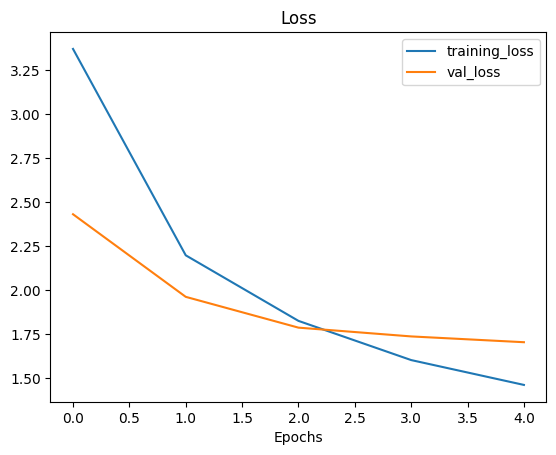

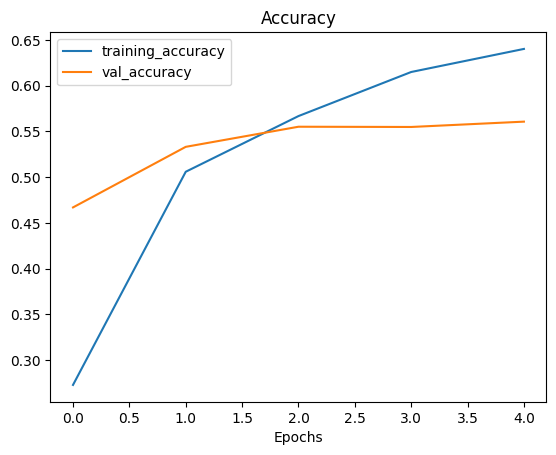

In [ ]:
plot_loss_curves(history_model_10_percent)

> What to these curves suggest?(Ideally these curves should be similar to each other.) Here the training accuracy surpasses validation accuracy, which means the model is learning well from the train data but unable to do accurate predictions on unseen data. i.e.*overfitting*





## Fine-Tuning

In [ ]:
# Unfreeze all of the layers in base model
base_model.trainable = True

#Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False


In [ ]:
#recompile model with lower learning rate(it is typically a best practice to lower learning rate)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #learning rate lowered by 10x
    metrics=["accuracy"]
)

In [ ]:
# what layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)


input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
# check which layers are trainable in our base model
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
#finetuning the model and fitting it for 5 epochs
history_fine_tune_5_layer = model.fit(
    train_data_all_10_percent,
    initial_epoch=5,
    epochs=10,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data))
)

Epoch 6/10
237/237 [==============================] - 81s 304ms/step - loss: 1.2113 - accuracy: 0.6776 - val_loss: 1.6739 - val_accuracy: 0.5614
Epoch 7/10
237/237 [==============================] - 74s 310ms/step - loss: 1.1033 - accuracy: 0.7028 - val_loss: 1.6662 - val_accuracy: 0.5609
Epoch 8/10
237/237 [==============================] - 64s 268ms/step - loss: 1.0144 - accuracy: 0.7299 - val_loss: 1.6590 - val_accuracy: 0.5654
Epoch 9/10
237/237 [==============================] - 59s 245ms/step - loss: 0.9561 - accuracy: 0.7465 - val_loss: 1.6561 - val_accuracy: 0.5649
Epoch 10/10
237/237 [==============================] - 56s 234ms/step - loss: 0.8828 - accuracy: 0.7675 - val_loss: 1.6476 - val_accuracy: 0.5686


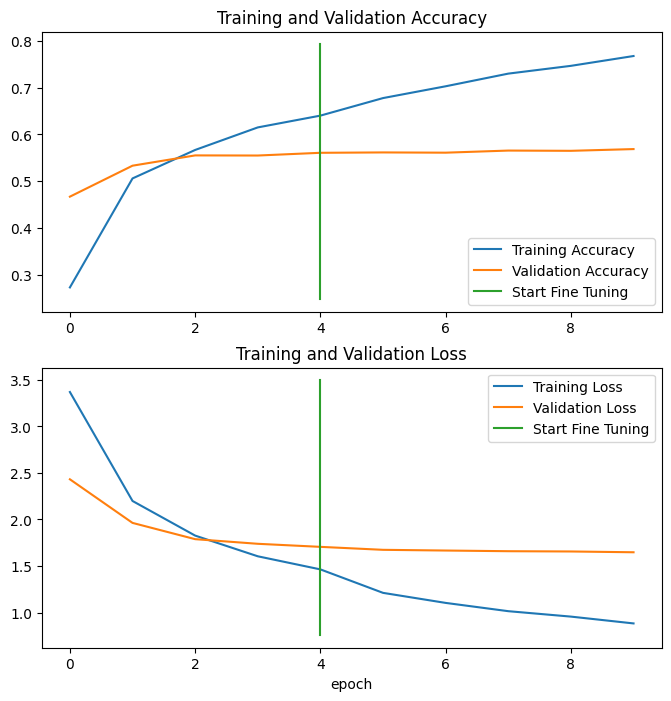

In [ ]:
compare_historys(history_model_10_percent, history_fine_tune_5_layer)

In [ ]:
#evaluate on entire test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 60s 76ms/step - loss: 1.5280 - accuracy: 0.5964


[1.527964472770691, 0.5963960289955139]

In [ ]:
fine_tune_results

[1.6020230054855347, 0.5784158706665039]

## Saving and loading our model

To use our model in an external application, we will need to save and export it somewhere.

In [ ]:
# save our finetuned model
# model.save("drive/My Drive/Colab Notebooks/101_food_classes_10_percent_model")

In [ ]:
# load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/101_food_classes_10_percent_model")

In [ ]:
#evaluate loaded model and compaired it to presave model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 72ms/step - loss: 1.4917 - accuracy: 0.6019


[1.4916929006576538, 0.6019009947776794]

## Evaluating the perfomance of our model across all different classes

Let's make some predictions, visualize them and later find out which predictions were the "most" wrong.

In [ ]:
#download a pretrained model, so all predictions are similar
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2024-04-16 15:51:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  24.9MB/s    in 1.8s    

2024-04-16 15:51:11 (24.9 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
#load the pretrained model
model_pretrained = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
#evaluate loaded model(the one we just downloaded)
results_pretrained_model = model_pretrained.evaluate(test_data)
results_pretrained_model

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with our model
pred_probs = model_pretrained.predict(test_data, verbose=1)


790/790 [==============================] - 67s 83ms/step


In [ ]:
# how many predictions are there
len(pred_probs)

25250

In [ ]:
# what is the shape of our predictions
pred_probs.shape

(25250, 101)

In [ ]:
#check what the first 10 predictions look like
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [ ]:
#checking the how the first prediction looks like
pred_probs[0], pred_probs[0].shape, sum(pred_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

Our model outputs are prediction probabilities array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# we get one prediction probability per class in that case we have 101 prediction probabilities
print(f"Number of prediction probabilities for sample 0:{len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like : {pred_probs[0]}")
print(f"The class with the highest predicted probability by our model for sample 0:{tf.argmax(pred_probs[0])}")

Number of prediction probabilities for sample 0:101
What prediction probability sample 0 looks like : [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-0

In [ ]:
# Get the pred classes of each label
pred_classes = tf.argmax(pred_probs, axis=1)

#how do they look
pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])>

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we have our predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test label look like :[0,0,0,0,1,0....0], we want the index value where "1" occurs

# look at the first 10
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_label we have
len(y_labels)

25250

## Evaluate our model's predictions

One way to check our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_pretrained_model

[1.8027204275131226, 0.6077623963356018]

In [ ]:
# Let's try scikit-learns accuracy function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(sklearn_accuracy, results_pretrained_model[1])

True

## Making a confusion matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-axis labesl vertically) ##
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      classes=class_names, figsize=(100,100),
                      text_size=20,
                      savefig=True)

## Let's continue evaluating the model, Let's make a classification report

Scikit-Learn has a helpful function for aquiring many differrent classification metrics per class (eg. precision, recall and F1) called classification_report.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.29      0.20      0.24       250
         baby_back_ribs       0.51      0.69      0.59       250
                baklava       0.56      0.65      0.60       250
         beef_carpaccio       0.74      0.53      0.62       250
           beef_tartare       0.73      0.43      0.54       250
             beet_salad       0.34      0.54      0.42       250
               beignets       0.67      0.79      0.72       250
               bibimbap       0.82      0.76      0.79       250
          bread_pudding       0.40      0.37      0.39       250
      breakfast_burrito       0.62      0.44      0.51       250
             bruschetta       0.62      0.42      0.50       250
           caesar_salad       0.84      0.49      0.62       250
                cannoli       0.52      0.74      0.61       250
          caprese_salad       0.56      0.60      0.58       250
            carrot_cake 

The numbers above give a great class by class evaluation of our model's predictions but with so many classes, they are quite hard to understand.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores.

In [ ]:
# Create empty dictionary
class_f1_scores = {

}

#Loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k=="accuracy": #stop once we get to accuracy
    break
  else:
    # Add class names and F1 scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']

In [ ]:
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframes for visualisation
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1_score":list(class_f1_scores.values())}).sort_values("f1_score",ascending=False)

f1_scores

class_names  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

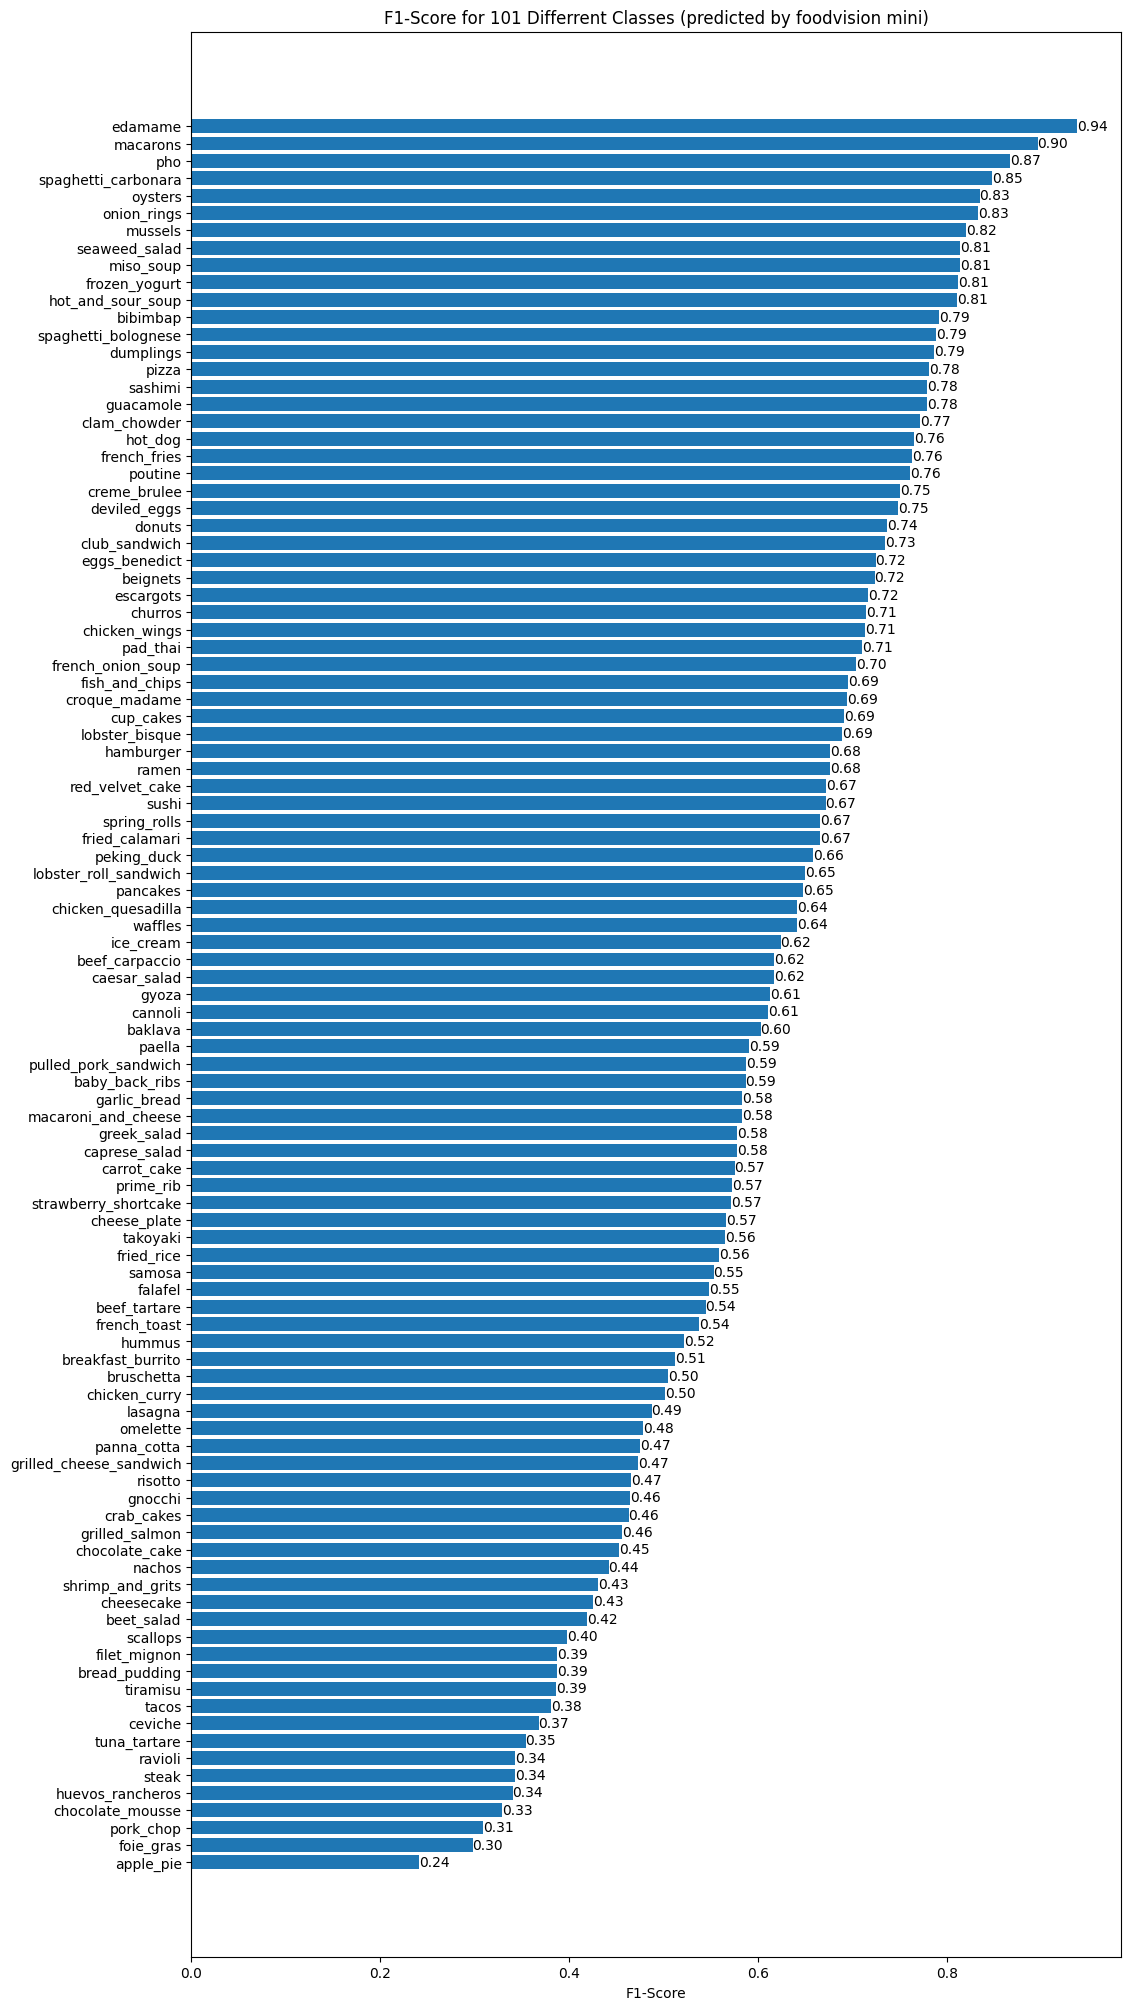

In [ ]:
#plotting a horizontal bar chart for f1 score

fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores.f1_score.values) #get f1 score values
ax.bar_label(scores, fmt='%.2f') #setting label on the bar
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores.class_names.values)
ax.set_xlabel("F1-Score")
ax.set_title("F1-Score for 101 Differrent Classes (predicted by foodvision mini)")
ax.invert_yaxis() #reverse the order of our plot
plt.show()

## Visualizing predictions on custom images

Now this is the real test, how does our model go on food images not even in our test dataset(images of our own)

To visualize the model's predictions on our own images, we will need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the images to get all of the pixel values between 0 and 1 (if necessary)

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turn it into a tensor and reshape into specified shape
  (img_shape, img_shape, color_channels = 3).

  Args:
  filename:str, path to image
  image_shape:int, height/width dimension of the target image size
  scale:bool, scaled pixel values from 0-255 to 0-1 or not

  Returns:
  image_tensor: tensor, of shape (img_shape,img_shape,3)
  """
  #read the image
  img = tf.io.read_file(filename)

  #Decode the image tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, (img_shape,img_shape))

  #Scale images? Yes/No
  if scale:
    #Scale images
    img = img/255.0

  #expanding the dims of image for making it compatiable with model.predict()
  return tf.expand_dims(img, axis=0)


Now we have a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically we will write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images.
3. Plot the original images(s) along with the model's predictions, prediction probability and truth label.

1/1 [==============================] - 0s 31ms/step


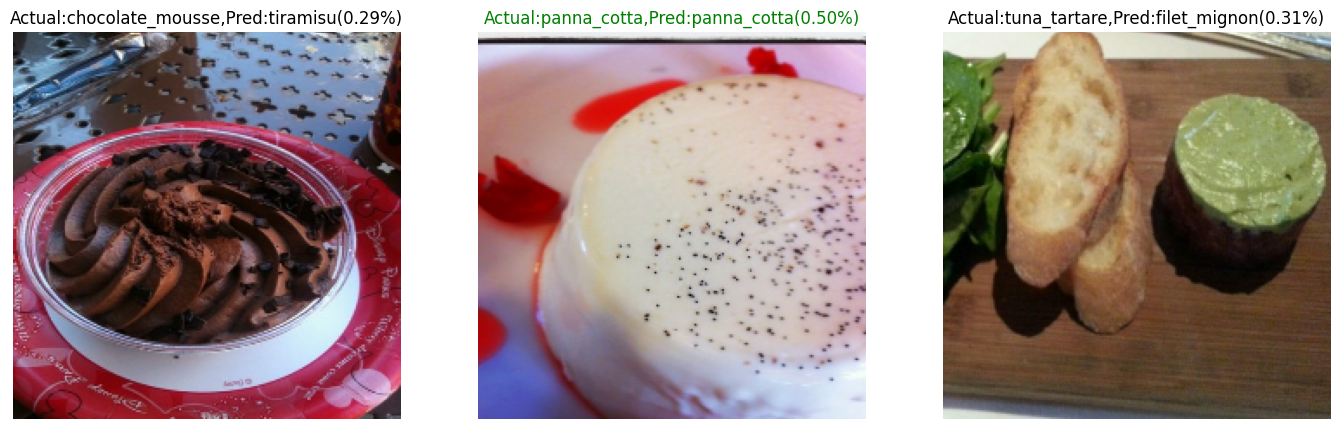

In [ ]:
# Make predictions on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  #Choosing a random image from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+class_name+"/"))
  filepath = test_dir+class_name+"/"+filename

  #Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(img) #get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] #get prediction probability index
  # print(pred_prob, pred_class)
  # print(class_name)

  # Plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(tf.squeeze(img)/255.0)
  #if predicted class matches actual class make the title color green
  if class_name == pred_class:
    title_color = "green"
  else:
    title_color="black"

  plt.title(f"Actual:{class_name},Pred:{pred_class}({pred_prob.max():.2f}%)", c=title_color)
  plt.axis("off")


## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the follwing:

1. Get all of the image file paths in the dataset using list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted  classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our dataframe to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the dataframe based on wrong predictions (have the highest prediction probabilities at the top).
5. Visualize the images with highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get allof the image filepaths in the test dataset
filepaths = []

for filepath in test_data.list_files(test_dir+"*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

In [ ]:
filepaths

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg',
 b'101_food_classes_10_percent/test/apple_pie/116705.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1167170.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1174330.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1180600.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1235282.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1269202.jpg',
 b'101_food_classes_10_percent/test/apple_pi

In [ ]:
# 2. Create a DataFrame of differrent parameters for each of our test images

import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":pred_probs.max(axis=1),#get the maximum prediction probability value
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})

In [ ]:
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# Find out in our dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"]==pred_df["y_pred"]
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847418        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367901        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501950          waffles  strawberry_shortcake         False  
25249   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [ ]:
# 4. Sort our dataframe to have most wrong predictions at top
top_100_wrong = pred_df[pred_df["pred_correct"]== False].sort_values("pred_conf", ascending=False)
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

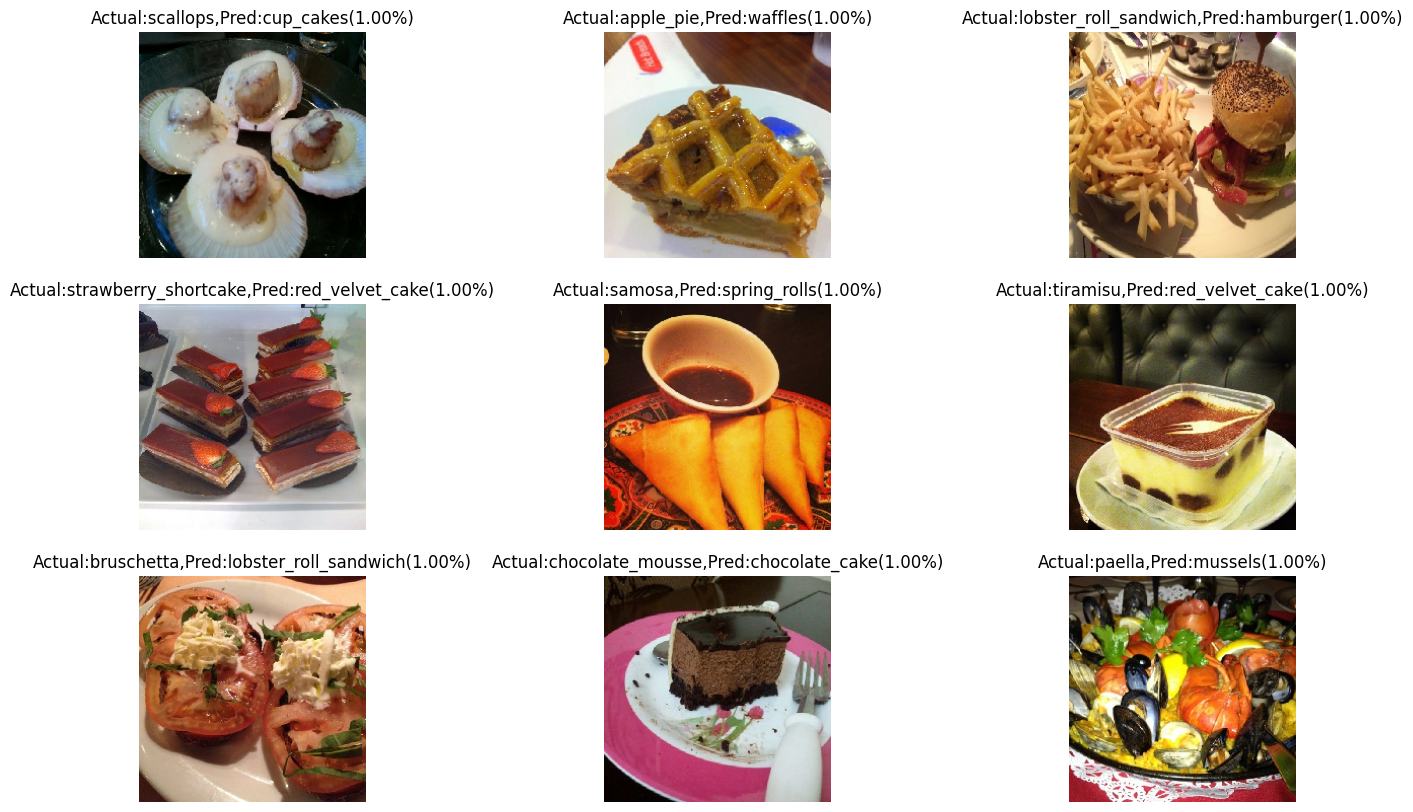

In [ ]:
# 5. Visualize the data samples which have the wrong predictions but highest pred probabiities

plt.figure(figsize=(17,10))
for i in range(9):
  plt.subplot(3,3, i+1)
  #getting the necessary column values from df
  image_path = top_100_wrong.iloc[i].img_path
  pred_label = top_100_wrong.iloc[i].y_pred_classname
  actual_label = top_100_wrong.iloc[i].y_true_classname
  pred_prob = top_100_wrong.iloc[i].pred_conf

  #plotting the image
  plt.imshow(tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224)))
  plt.title(f"Actual:{actual_label},Pred:{pred_label}({pred_prob:.2f}%)")
  plt.axis("off")


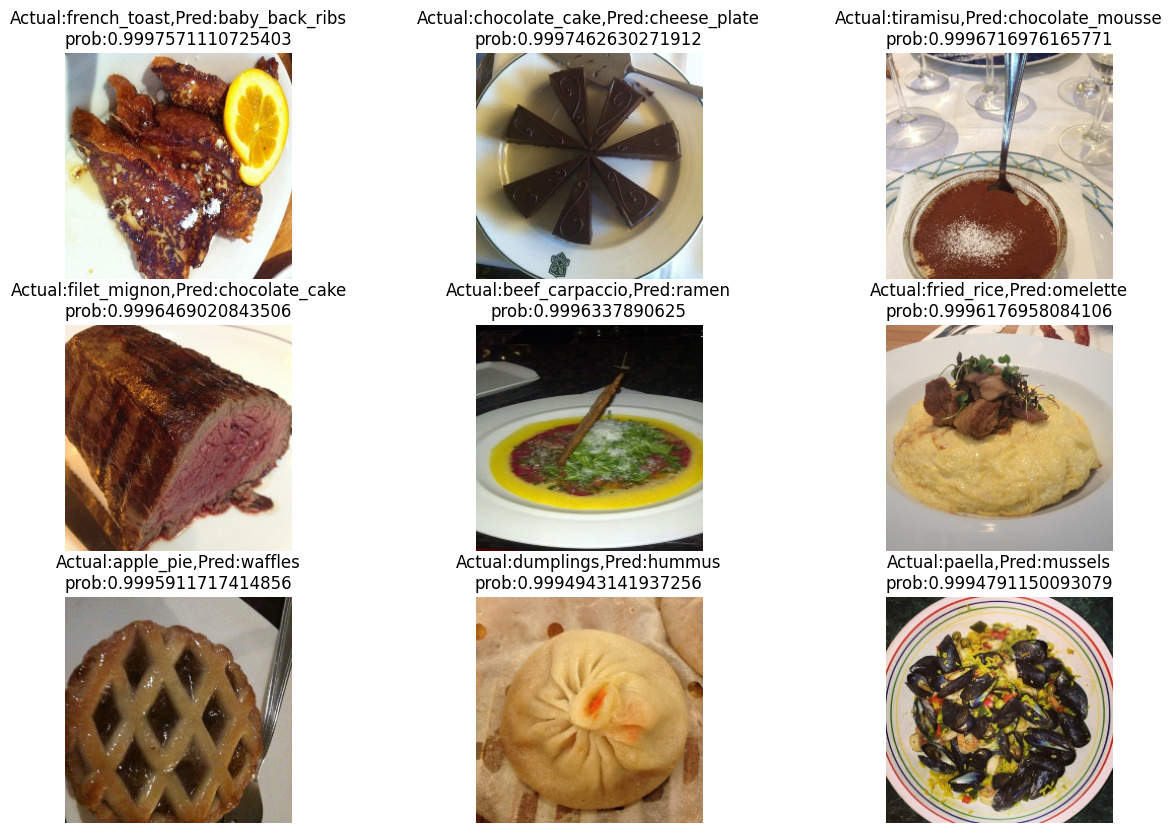

In [ ]:
# Aleternatively
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_image(row.img_path, scale=False)
  plt.imshow(tf.squeeze(img)/255.0)
  plt.title(f"Actual:{row.y_true_classname},Pred:{row.y_pred_classname}\nprob:{row.pred_conf}")
  plt.axis("off")

## Test out the model on our own custom images

In [ ]:
# Get custom images
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip"

unzip_data("custom_food_images.zip")


--2024-04-16 15:55:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  13.8MB/s    in 0.9s    

2024-04-16 15:55:54 (13.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images file paths
custom_food_images = ["custom_food_images/"+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 [==============================] - 0s 40ms/step


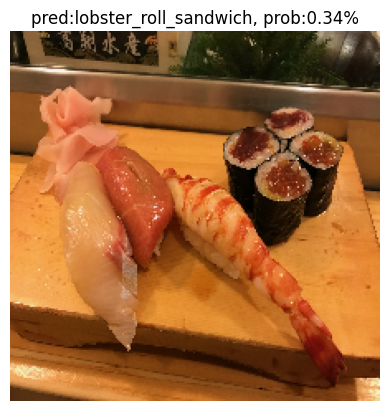

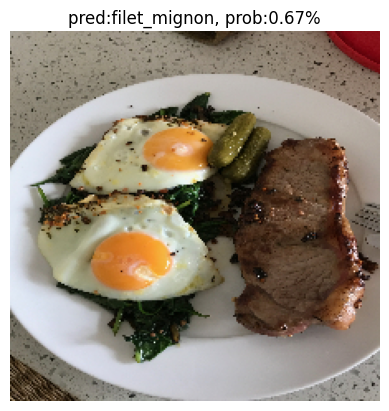

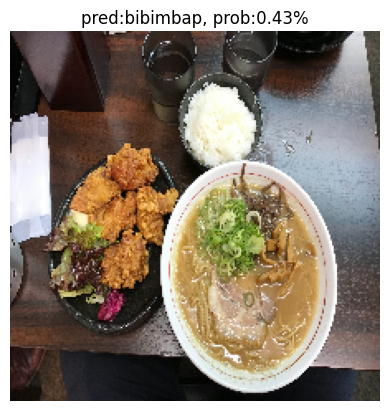

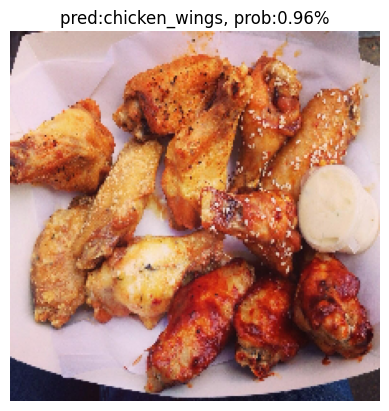

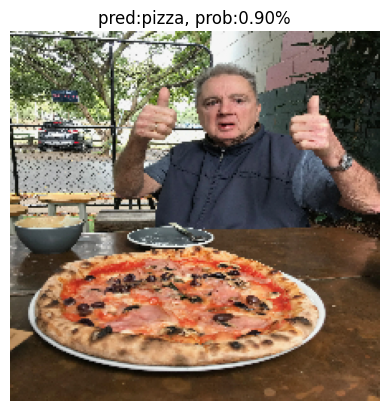

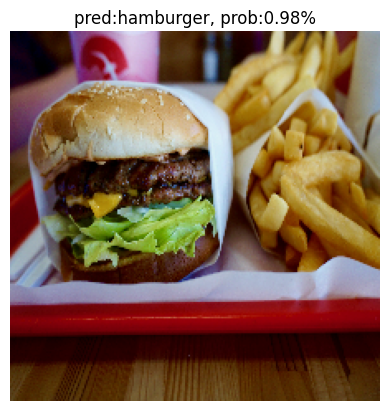

In [ ]:
# Make predictions on and plot the custom images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(img)
  pred_class = class_names[pred_prob.argmax()]
  #plot the appropriate information
  plt.figure()
  plt.imshow(tf.squeeze(img)/255.0)
  plt.title(f"pred:{pred_class}, prob:{pred_prob.max():.2f}%")
  plt.axis("off")

## Practice Problems

1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
2. Recreate the first model (the feature extraction model) with mixed_precision turned on.
 * Does it make the model train faster?
 * Does it effect the accuracy or performance of our model?
 * What's the advantages of using mixed_precision training?

In [ ]:
#training a feature extraction model for 10 epochs

#creating a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False
#defining input shape
input_shape=(224,224,3)

#defining input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#passing the input layer through augmentaion layer
x = data_augmentation(inputs)

#passing the augmented data to the backbone model
x = base_model(x, training=False)

#adding a global average pooling layer
x = layers.GlobalAveragePooling2D(name="global_avg_pooling2D")(x)

#adding an output layer
outputs = layers.Dense(101, activation="softmax")(x)

#creating model
model_10_epochs = tf.keras.Model(inputs, outputs)

#compiling the model
model_10_epochs.compile(optimizer="adam",
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

#training the model on 10 epochs
history_model_10_epochs = model_10_epochs.fit(train_data_all_10_percent,
                                            epochs=10,
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)))


Epoch 1/10
237/237 [==============================] - 69s 262ms/step - loss: 3.3810 - accuracy: 0.2759 - val_loss: 2.3944 - val_accuracy: 0.4812
Epoch 2/10
237/237 [==============================] - 54s 227ms/step - loss: 2.1985 - accuracy: 0.5026 - val_loss: 2.0001 - val_accuracy: 0.5262
Epoch 3/10
237/237 [==============================] - 51s 214ms/step - loss: 1.8290 - accuracy: 0.5679 - val_loss: 1.8574 - val_accuracy: 0.5355
Epoch 4/10
237/237 [==============================] - 51s 213ms/step - loss: 1.6072 - accuracy: 0.6124 - val_loss: 1.7660 - val_accuracy: 0.5456
Epoch 5/10
237/237 [==============================] - 47s 196ms/step - loss: 1.4564 - accuracy: 0.6494 - val_loss: 1.7376 - val_accuracy: 0.5474
Epoch 6/10
237/237 [==============================] - 47s 195ms/step - loss: 1.3283 - accuracy: 0.6763 - val_loss: 1.6992 - val_accuracy: 0.5606
Epoch 7/10
237/237 [==============================] - 48s 199ms/step - loss: 1.2163 - accuracy: 0.7017 - val_loss: 1.6925 - val_ac

In [ ]:
#evaluating the model on complete test data
model_10_epochs.evaluate(test_data)

790/790 [==============================] - 62s 79ms/step - loss: 1.5177 - accuracy: 0.5955


[1.5177339315414429, 0.5955247282981873]

In [ ]:
#compairing with finetuned model of 10 epochs
all_classes_10_percent_fine_tune_results

[1.527964472770691, 0.5963960289955139]

There is no significant differrence in the results

In [ ]:
# turning on mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
#recreating the model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

#creating input layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")

#passing the inputs into augmentation layer
x = data_augmentation(inputs)

#passing the augmented inputs to base model
x = base_model(x, training=False)

#passing the base_model outputs to global average pooling layer
x = layers.GlobalAveragePooling2D(name="global_avg_pooling2D")(x)

#passing the global average pooling layer outputs to output layer
outputs = layers.Dense(101, activation="softmax")(x)

#creating model
model_mixed_precision = tf.keras.Model(inputs, outputs)

#compiling the model
model_mixed_precision.compile(optimizer="adam",
                              loss="categorical_crossentropy",
                              metrics=["accuracy"])
#fitting the model for 10 epochs
history_mixed_precions = model_mixed_precision.fit(train_data_all_10_percent,
                                                  epochs=10,
                                                  validation_data=test_data,
                                                  validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
237/237 [==============================] - 92s 348ms/step - loss: 3.3758 - accuracy: 0.2669 - val_loss: 2.4003 - val_accuracy: 0.4841
Epoch 2/10
237/237 [==============================] - 65s 269ms/step - loss: 2.2035 - accuracy: 0.4931 - val_loss: 1.9537 - val_accuracy: 0.5405
Epoch 3/10
237/237 [==============================] - 59s 246ms/step - loss: 1.8158 - accuracy: 0.5677 - val_loss: 1.8175 - val_accuracy: 0.5503
Epoch 4/10
237/237 [==============================] - 56s 235ms/step - loss: 1.6096 - accuracy: 0.6062 - val_loss: 1.7090 - val_accuracy: 0.5633
Epoch 5/10
237/237 [==============================] - 52s 219ms/step - loss: 1.4459 - accuracy: 0.6499 - val_loss: 1.6704 - val_accuracy: 0.5649
Epoch 6/10
237/237 [==============================] - 51s 215ms/step - loss: 1.3219 - accuracy: 0.6731 - val_loss: 1.6716 - val_accuracy: 0.5636
Epoch 7/10
237/237 [==============================] - 52s 215ms/step - loss: 1.2221 - accuracy: 0.6990 - val_loss: 1.6461 - val_ac

In [ ]:
model_mixed_precision.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.5118 - accuracy: 0.5947


[1.5118438005447388, 0.5946534872055054]

Mixed precision used the float16 and float32 for storing numbers. This makes the model training much faster. mixed precision is supported by nvidia GPU's.

After enabling mixed precision the model's training speed has no significant impact. there is a slight increment in accuracy and very minimal in loss of validation.